In [1]:
import os
import pandas as pd
import numpy as np
from siuba import *
from siuba.dply.vector import * 
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import time

In [2]:
os.chdir('C:\\Users\\jaker\\Documents\\Python Scripts\\ML_Py_23-main\\data')
cancer = pd.read_csv("cancer_mama.csv")

In [3]:
cancer.head(3)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,diagnosis
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [4]:
# Aplicamos un cambio para los dígitos 0 y 1 y los intercambiamos, de tal manera que 
# entonces 0=cancer benigno y 1= cancer maligno 
cancer = cancer >> mutate(diagnosis = _.diagnosis.replace({0:1,1:0}))

<AxesSubplot: >

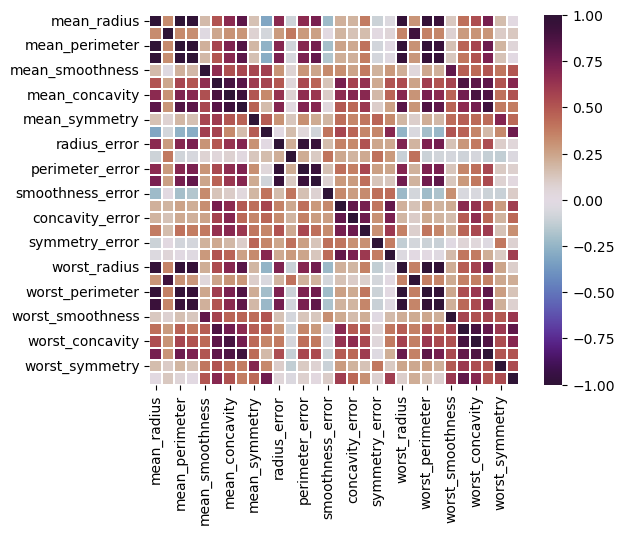

In [5]:
correlaciones = (cancer >> select(-_.diagnosis)).corr()
sns.heatmap(data=correlaciones,
            vmax=1,vmin=-1,
            cmap="twilight_shifted",
            linecolor="white",linewidth=0.1,
            square=True,
            annot=False,fmt=".2f")

In [6]:
# Dada la naturaleza de los datos, tendremos que utilizar métodos para eliminar la multicolinealidad
# Para este caso, puesto que quiero reducirlo lo mejor, según la información que ahora sé haré análisis
# de componentes principales PCA 

In [7]:
# Primero que nada voy a quitar la 'y' objetivo

matrix = cancer >> select(-_.diagnosis)

In [8]:
matrix.var()[matrix.var()>50]

mean_perimeter        590.440480
mean_area          123843.554318
area_error           2069.431583
worst_perimeter      1129.130847
worst_area         324167.385102
dtype: float64

In [9]:
# Aplicaré 2 métodos de escalado
bigvar = (matrix.var()[matrix.var()>50]).index.tolist()
big_var = matrix[bigvar]
small_var = matrix.drop(bigvar,axis=1)

In [10]:
# Para ingresar los datos aplicamos también un escalado para los datos,

from sklearn import preprocessing

escalador = preprocessing.StandardScaler()
robusto = preprocessing.RobustScaler()

escalado_normal = escalador.fit_transform(small_var)
escalado_robusto = robusto.fit_transform(big_var)

normales = pd.DataFrame(escalado_normal,
                        index=small_var.index,
                        columns=small_var.columns)
robustas = pd.DataFrame(escalado_robusto,
                        index=big_var.index,
                        columns=big_var.columns)

In [11]:
matriz = normales.merge(robustas,left_index=True,right_index=True)

In [12]:
# En éste primer apartado lo que vamos a hacer es determinar con cuántos parámetros(n_components)
# vamos a quedarnos para hacer el PCA, éste paso es crucial

In [13]:
from sklearn.decomposition import PCA
pca = PCA().fit(matriz)
np.cumsum(pca.explained_variance_ratio_)

array([0.44453761, 0.6308345 , 0.72846753, 0.7933589 , 0.84753542,
       0.88649864, 0.91199966, 0.92748509, 0.94126402, 0.95260165,
       0.96206508, 0.97046771, 0.97822649, 0.98332069, 0.98632224,
       0.9889034 , 0.99131624, 0.99311128, 0.99469715, 0.99574874,
       0.99671927, 0.99760087, 0.99838569, 0.99895338, 0.99945109,
       0.99970825, 0.99993367, 0.99997365, 0.99999645, 1.        ])

In [14]:
# Con el PCA podemos llegar a los 5 componentes y conservar los datos más importantes en al menos 80%

In [15]:
# Por tanto aplicamos el PCA
pca = PCA(n_components=5)
pca.fit(matriz)
scores = pca.transform(matriz)

In [16]:
# Esta es la nueva tabla con la que nos quedamos y que usaremos para hacer la regresión
cancer_PCA = pd.merge(pd.DataFrame(scores),cancer['diagnosis'],left_index=True,right_index=True)
cancer_PCA.head(3)

,0,1,2,3,4,diagnosis
0,9.624746,1.861817,-0.440827,3.981427,-0.976081,1
1,2.404559,-3.555288,-0.889828,0.972984,0.822770,1
2,5.824362,-0.887763,-0.752477,0.880438,0.005366,1


In [17]:
# Como se puede apreciar, no es severo la diferencia entre clases por lo que no se pondera algun peso en especial

cancer_PCA >> group_by(_.diagnosis) >> summarize(diagnosticos = n(_))

,diagnosis,diagnosticos
0,0,357
1,1,212


In [18]:
X = cancer_PCA >> select(-_.diagnosis)
y = cancer_PCA >> select(_.diagnosis)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

In [20]:
# Defino las funciones que me ayudarán a testear los modelos

def evaluar_modelo(estimador, X, y):
    resultados_estimador = cross_validate(estimador, X, y,
                     scoring="f1_micro", n_jobs=-1, cv=10)
    return resultados_estimador

def ver_resultados():
    resultados_df  = pd.DataFrame(resultados).T
    resultados_cols = resultados_df.columns
    for col in resultados_df:
        resultados_df[col] = resultados_df[col].apply(np.mean)
        resultados_df[col+"_idx"] = resultados_df[col] / resultados_df[col].max()
    return resultados_df >> arrange(-_.test_score,_.fit_time)


In [21]:
# Establecemos una variable para guardar los resultados

resultados = {}

resultados['regresion_logistica'] = evaluar_modelo(LogisticRegression(),
                                   X,
                                   y.values.ravel())
resultados["knn"] = evaluar_modelo(KNeighborsClassifier(),
                                   X,
                                   y.values.ravel())
resultados["arbol_clasificacion"] = evaluar_modelo(tree.DecisionTreeClassifier(),
                                   X,
                                   y.values.ravel())
resultados["arbol_aleatorio"] = evaluar_modelo(tree.ExtraTreeClassifier(),
                                   X,
                                   y.values.ravel())
resultados["msv"] = evaluar_modelo(SVC(),
                                   X,
                                   y.values.ravel())

pd.set_option('display.expand_frame_repr', False)
ver_resultados()

,fit_time,score_time,test_score,fit_time_idx,score_time_idx,test_score_idx
regresion_logistica,0.020046,0.008745,0.970144,1.000000,0.993693,1.000000
msv,0.006198,0.003801,0.961341,0.309205,0.431907,0.990926
knn,0.004998,0.008801,0.950721,0.249319,1.000000,0.979979
arbol_clasificacion,0.010296,0.005102,0.949091,0.513595,0.579660,0.978299
arbol_aleatorio,0.002902,0.004000,0.894518,0.144768,0.454479,0.922046


In [22]:
# Busco a través de la validación cruzada determinar los parámetros

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [23]:
estimador_reg_logistica = LogisticRegression()
#print(estimador_reg_logistica.__doc__)
estimador_reg_logistica.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [24]:
parametros_busqueda_reglog = {
    'penalty': ['l2', None],
    'solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']
}

reg_logistica_grid = GridSearchCV(estimator=estimador_reg_logistica, 
                                  param_grid=parametros_busqueda_reglog,
                                  scoring="f1_micro",
                                  n_jobs=-1)

start_time = time.time()

reg_logistica_grid.fit(X, y.values.ravel())

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")
print(f'Best score: {reg_logistica_grid.best_score_}')
print(reg_logistica_grid.best_estimator_.get_params())

resultados["reg_logistica_gridsearch"] = evaluar_modelo(reg_logistica_grid.best_estimator_,
                                                        X,
                                                        y.values.ravel())

ver_resultados()

Elapsed time: 0.10452508926391602 seconds
Best score: 0.9736686849868033
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


,fit_time,score_time,test_score,fit_time_idx,score_time_idx,test_score_idx
reg_logistica_gridsearch,0.004097,0.003100,0.970144,0.204386,0.352257,1.000000
regresion_logistica,0.020046,0.008745,0.970144,1.000000,0.993693,1.000000
msv,0.006198,0.003801,0.961341,0.309205,0.431907,0.990926
knn,0.004998,0.008801,0.950721,0.249319,1.000000,0.979979
arbol_clasificacion,0.010296,0.005102,0.949091,0.513595,0.579660,0.978299
arbol_aleatorio,0.002902,0.004000,0.894518,0.144768,0.454479,0.922046


In [25]:
estimador_knn = KNeighborsClassifier()
#print(estimador_knn.__doc__)
estimador_knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [26]:
parametros_busqueda_knn = {
    "n_neighbors": np.arange(1,50,2).tolist(),
    "p": [1,2,3],
    "weights": ["uniform", "distance"]
}


knn_grid = GridSearchCV(estimator=estimador_knn, 
                    param_grid=parametros_busqueda_knn,
                    scoring="f1_micro", n_jobs=-1)

start_time = time.time()

knn_grid.fit(X, y.values.ravel())

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")
print(f'Best score: {knn_grid.best_score_}')
print(knn_grid.best_estimator_.get_params())

resultados["knn_gridsearch"] = evaluar_modelo(knn_grid.best_estimator_,
                                              X,
                                              y.values.ravel())

ver_resultados()

Elapsed time: 1.1400721073150635 seconds
Best score: 0.9666511411271543
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 21, 'p': 2, 'weights': 'distance'}


,fit_time,score_time,test_score,fit_time_idx,score_time_idx,test_score_idx
reg_logistica_gridsearch,0.004097,0.003100,0.970144,0.204386,0.352257,1.000000
regresion_logistica,0.020046,0.008745,0.970144,1.000000,0.993693,1.000000
msv,0.006198,0.003801,0.961341,0.309205,0.431907,0.990926
knn_gridsearch,0.002201,0.004101,0.961310,0.109819,0.465976,0.990894
knn,0.004998,0.008801,0.950721,0.249319,1.000000,0.979979
arbol_clasificacion,0.010296,0.005102,0.949091,0.513595,0.579660,0.978299
arbol_aleatorio,0.002902,0.004000,0.894518,0.144768,0.454479,0.922046


In [27]:
estimador_tree = tree.DecisionTreeClassifier()
#print(estimador_tree.__doc__)
estimador_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [28]:
parametros_busqueda_tree = {
    'criterion': ["gini", "entropy", "log_loss"]
}


#%%
tree_grid = GridSearchCV(estimator=estimador_tree, 
                        param_grid=parametros_busqueda_tree,
                        scoring="roc_auc",
                        n_jobs=-1)

start_time = time.time()
tree_grid.fit(X, y.values.ravel())
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")
print(tree_grid.best_estimator_)
print(tree_grid.best_estimator_.get_params())

resultados["tree_gridsearch"] = evaluar_modelo(tree_grid.best_estimator_,
                                               X,
                                               y.values.ravel())

ver_resultados()

Elapsed time: 0.04320049285888672 seconds
DecisionTreeClassifier(criterion='log_loss')
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'log_loss', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': None, 'splitter': 'best'}


,fit_time,score_time,test_score,fit_time_idx,score_time_idx,test_score_idx
reg_logistica_gridsearch,0.004097,0.003100,0.970144,0.204386,0.352257,1.000000
regresion_logistica,0.020046,0.008745,0.970144,1.000000,0.993693,1.000000
msv,0.006198,0.003801,0.961341,0.309205,0.431907,0.990926
knn_gridsearch,0.002201,0.004101,0.961310,0.109819,0.465976,0.990894
knn,0.004998,0.008801,0.950721,0.249319,1.000000,0.979979
arbol_clasificacion,0.010296,0.005102,0.949091,0.513595,0.579660,0.978299
tree_gridsearch,0.003960,0.002809,0.949029,0.197541,0.319123,0.978235
arbol_aleatorio,0.002902,0.004000,0.894518,0.144768,0.454479,0.922046


In [29]:
estimador_svm = SVC()
#print(estimador_svm.__doc__)
estimador_svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [30]:
parametros_busqueda_svm = {
    "degree": [1,2,3],
    "gamma": [0.1,0.5,1.,10.],
    "kernel": ["poly", "rbf"]
}


svm_random = RandomizedSearchCV(estimator=estimador_svm, 
                                param_distributions=parametros_busqueda_svm,
                                scoring="f1_micro",
                                n_jobs=-1,
                                n_iter=10)

start_time = time.time()
svm_random.fit(X, y.values.ravel())
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")
print(f'Best score: {svm_random.best_estimator_}')
print(svm_random.best_estimator_.get_params())
resultados["svm_randomizedsearch"] = evaluar_modelo(svm_random.best_estimator_,
                                                    X,
                                                    y.values.ravel())

ver_resultados()

Elapsed time: 0.901308536529541 seconds
Best score: SVC(degree=1, gamma=0.1, kernel='poly')
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 1, 'gamma': 0.1, 'kernel': 'poly', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


,fit_time,score_time,test_score,fit_time_idx,score_time_idx,test_score_idx
svm_randomizedsearch,0.004419,0.003207,0.975376,0.220435,0.364420,1.000000
reg_logistica_gridsearch,0.004097,0.003100,0.970144,0.204386,0.352257,0.994636
regresion_logistica,0.020046,0.008745,0.970144,1.000000,0.993693,0.994636
msv,0.006198,0.003801,0.961341,0.309205,0.431907,0.985611
knn_gridsearch,0.002201,0.004101,0.961310,0.109819,0.465976,0.985578
knn,0.004998,0.008801,0.950721,0.249319,1.000000,0.974722
arbol_clasificacion,0.010296,0.005102,0.949091,0.513595,0.579660,0.973052
tree_gridsearch,0.003960,0.002809,0.949029,0.197541,0.319123,0.972988
arbol_aleatorio,0.002902,0.004000,0.894518,0.144768,0.454479,0.917100


In [31]:
ver_resultados()

,fit_time,score_time,test_score,fit_time_idx,score_time_idx,test_score_idx
svm_randomizedsearch,0.004419,0.003207,0.975376,0.220435,0.364420,1.000000
reg_logistica_gridsearch,0.004097,0.003100,0.970144,0.204386,0.352257,0.994636
regresion_logistica,0.020046,0.008745,0.970144,1.000000,0.993693,0.994636
msv,0.006198,0.003801,0.961341,0.309205,0.431907,0.985611
knn_gridsearch,0.002201,0.004101,0.961310,0.109819,0.465976,0.985578
knn,0.004998,0.008801,0.950721,0.249319,1.000000,0.974722
arbol_clasificacion,0.010296,0.005102,0.949091,0.513595,0.579660,0.973052
tree_gridsearch,0.003960,0.002809,0.949029,0.197541,0.319123,0.972988
arbol_aleatorio,0.002902,0.004000,0.894518,0.144768,0.454479,0.917100


In [32]:
# Como se puede obvservar, los métodos utilizados dan puntuaciones muy eficientes aplicando cualquiera de los
# métodos de clasificación, dando a entender que el procedimiento para poder ejectutar esta clasificación
# fue excelente, es decir, donde la puntuación f1 score nos da un rendimiento equilibrado entre la precisión
# y la sensibilidad